In [1]:
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from math import sqrt
import matplotlib.cm as cm
import seaborn as sns
from datetime import date, timedelta
import psutil
import os

# Get the current process ID of the IPython kernel
pid = os.getpid()
# Get the process associated with the IPython kernel
process = psutil.Process(pid)

from tqdm import tqdm  # For status process bar
# from IPython.display import clear_output
# import baostock as bs
import pickle

# Suppress the warning
# warnings.filterwarnings(
#     "ignore", 
#     category=pd.core.common.SettingWithCopyWarning)

# Suppress the warning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
Main_bactest = False
Online = False

# Get the directory of the Python script
path = os.getcwd() + '\\'
# path_Main = "/home/huh/"
path_HS300_Rolling = path
path_HS300_Rolling_pic = path + "Loss-pic\\"

begin_date = "20180101"
end_date = "20240430"
today_date = str(date.today())
if Main_bactest:
    end_date = today_date

In [2]:
date_all = pd.read_csv(path_HS300_Rolling + 'date_all.csv', 
                        index_col=0, 
                        parse_dates=True).index
date_train, date_backtest = train_test_split(date_all, test_size=0.2, shuffle=False)

In [3]:
date_backtest

DatetimeIndex(['2023-01-20', '2023-01-30', '2023-01-31', '2023-02-01',
               '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07',
               '2023-02-08', '2023-02-09',
               ...
               '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22',
               '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26',
               '2024-04-29', '2024-04-30'],
              dtype='datetime64[ns]', name='trade_date', length=307, freq=None)

### Get Data

In [9]:
def Ensemble(type):
    factor_list = []
    for i in range(-1, 62):
        filename = f'Ensemble_{type}_factor_df_Monday_{i}.csv'
        filepath = path_HS300_Rolling + filename
        df = pd.read_csv(filepath)
        factor_list.append(df)
    factor_df = pd.concat(factor_list, 
                          ignore_index=True)
    factor_df['trade_date'] = pd.to_datetime(factor_df['trade_date'])
    factor_df = factor_df.set_index('trade_date')

    Ensemble_factor_df = pd.DataFrame(index=date_backtest)
    Ensemble_factor_df = pd.concat([Ensemble_factor_df, factor_df], axis=1)
    Ensemble_factor_df.ffill(inplace=True)
    return Ensemble_factor_df

In [10]:
Ensemble_weight_factor_df = Ensemble('weight')

In [11]:
Ensemble_max_factor_df = Ensemble('max')

In [5]:
# weight_factor_df['trade_date'] = pd.to_datetime(weight_factor_df['trade_date'])
# weight_factor_df = weight_factor_df.set_index('trade_date')

In [6]:
# Ensemble_weight_factor_df = pd.DataFrame(index=date_backtest)
# Ensemble_weight_factor_df

In [7]:
# Ensemble_weight_factor_df = pd.concat([Ensemble_weight_factor_df, weight_factor_df], axis=1)

In [8]:
# Ensemble_weight_factor_df.ffill(inplace=True)
# Ensemble_weight_factor_df

In [101]:
# pd.merge(Ensemble_weight_factor_df, weight_factor_df, left_index=True, right_index=True, how='left')

### Back testing

In [12]:
# Split return rates data
price_return_backtest = pd.read_csv('price_return_backtest.csv',
                                    parse_dates=['trade_date'],
                                    index_col="trade_date")
benchmark_return_backtest = pd.read_csv('benchmark_return_backtest.csv',
                                        parse_dates=['trade_date'],
                                        index_col="trade_date")

HS_300_backtest = pd.read_csv(path + 'HS_300_backtest.csv',
                              parse_dates=["trade_date"],
                              index_col="trade_date")["000300.SH"]
CS_500_backtest = pd.read_csv(path + 'CS_500_backtest.csv',
                            parse_dates=["trade_date"],
                            index_col="trade_date")["000905.SH"]
CS_1000_backtest = pd.read_csv(path + 'CS_1000_backtest.csv',
                            parse_dates=["trade_date"],
                            index_col="trade_date")["000852.SH"]

# with open(path + 'stock_code.pkl', 'rb') as file:
#     stocks_code = pickle.load(file)

In [18]:
def Ensure_position(DF):
    # We add a column named 'Monday' and change positions every Monday.
    DF = DF.shift(1)  # Move one step forward to ensure position
    DF["Monday"] = (DF.index.dayofweek == 0).astype(int)  # Shift except Monday

    # Get the columns to shift (all columns except 'Monday')
    cols_to_shift = DF.columns[DF.columns != "Monday"]

    DF.loc[DF["Monday"] == 0, cols_to_shift] = np.nan
    # DF.fillna(
    #     method="ffill", inplace=True
    # )  # Forward fill, holing positions for a week.
    DF.ffill(inplace=True)
    DF.fillna(value=0, inplace=True)  # Fill remaining NaN with 0
    return DF

def Layer_Backtest(factor_df, type):
    # layer number
    num_layers = 20

    # Calculte the ranks of factors daily.
    factor_ranks = factor_df.rank(axis=1, ascending=False)

    # The factor ordering is divided into num_layers, each of which allocates funds equally.
    layer_allocation = (factor_ranks // (len(factor_df.columns) / num_layers)).fillna(0)
    layer_allocation

    # import matplotlib.cm as cm

    plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color="grey", linestyle="--")

    # Define a color map to use for changing colors progressively
    # colors = plt.cm.jet(np.linspace(0, 1, num_layers))

    global profit_long, profit_short
    profit_long = profit_short = None

    def Long_Short(Num_layers, Layer, Profit):
        global profit_long, profit_short
        long_layer = Num_layers - 1
        short_layer = 0
        if Layer == short_layer:
            profit_short = Profit
            # The short profit comes from the decline of the stock.
            profit_short = profit_short.apply(
                lambda x: x + 1 if x == 0 else -x + (1 - 0.0003)
            )
            profit_short = profit_short.cumprod()
            profit_short *= 0.5
        elif Layer == long_layer:
            profit_long = Profit
            profit_long = profit_long.apply(
                lambda x: x + 1 if x == 0 else x + (1 - 0.0003)
            )
            profit_long = profit_long.cumprod()
            profit_long *= 0.5

    Long_position_df = None
    for layer in range(0, num_layers):
        # Ensure holding stocks
        hold_flag_matrix = layer_allocation.mask(layer_allocation != layer, 0).mask(
            layer_allocation == layer, 1
        )
        hold_flag_matrix = Ensure_position(hold_flag_matrix)
        if layer == num_layers - 1:
            Long_position_df = hold_flag_matrix.copy()

        # Delete 'Monday' to fit into yield dataframe.
        del hold_flag_matrix["Monday"]

        # Calculate the sum of each line in turn.
        stock_amount_sum = hold_flag_matrix.sum(axis=1)

        # Calculate the weight of each stock. (Average distribution at the same level)
        weight_allocation = hold_flag_matrix.apply(
            lambda x: x / stock_amount_sum, axis=0
        ).fillna(0)

        # Calculate the daily profit rate. And prepare to calculate cumprod.
        profit = (weight_allocation * price_return_backtest).sum(axis=1)

        # Create Long and Short position
        Long_Short(num_layers, layer, profit)

        # Calculate the daily equity and draw.
        # Using the 'viridis' colormap with a gradient based on layer number
        colors = cm.viridis(layer / num_layers)
        profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit.cumprod().plot(label=layer, legend=True, color=colors)

    profit_HS300 = HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color="r")
    profit_CS500 = CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color="g")
    profit_CS1000 = CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color="b")

    (profit_long + profit_short).plot(color="orange", label="long_short", legend=True)
    plt.title(f"20-Layered Portfolio Equity ({type})")
    plt.legend(title="Layer", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

    return profit_long, Long_position_df

### Ensemble Backtest

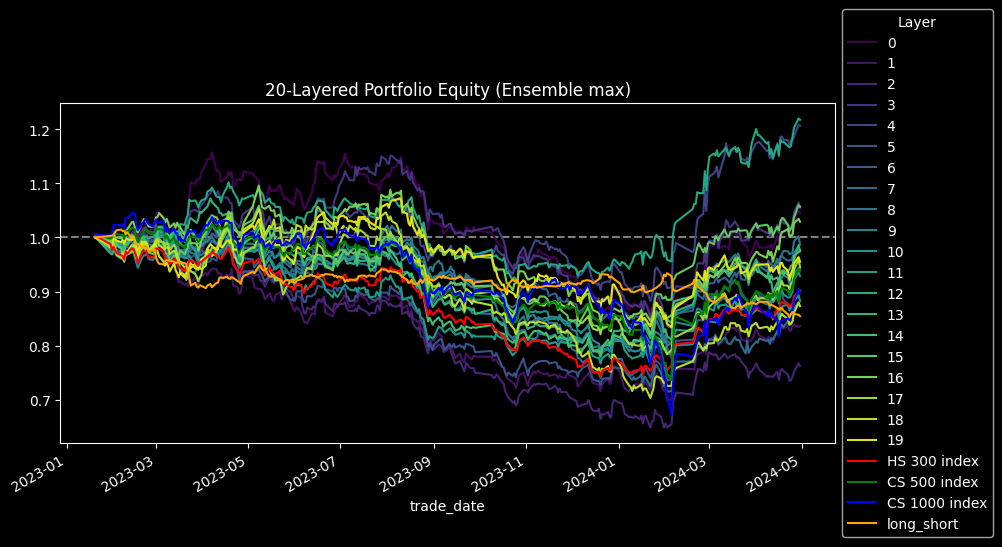

In [19]:
profit_long_Ensemble_max, \
Long_position_df_Ensemble_max = Layer_Backtest(Ensemble_max_factor_df, "Ensemble max")

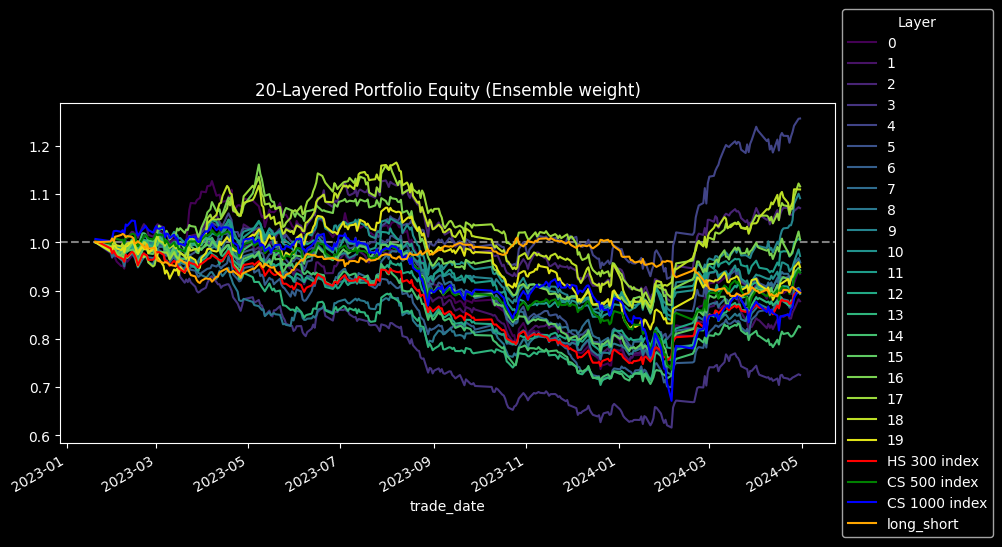

In [20]:
profit_long_Ensemble_weight, \
Long_position_df_Ensemble_weight = Layer_Backtest(Ensemble_weight_factor_df, "Ensemble weight")

### Simple Backtest
(Small number of stocks)

In [113]:
def Simple_Backtest(factor_df, stock_num, Ascending):
    # Calculte the ranks of factors daily.
    factor_ranks = factor_df.rank(axis=1, ascending=Ascending)

    # Create position_df based on top 3 ranks
    position_df = factor_ranks.apply(lambda x: x <= stock_num).astype(int)
    position_df = Ensure_position(position_df)

    # Delete 'Monday' to fit into yield dataframe.
    del position_df["Monday"]

    # Calculate the sum of each line in turn.
    stock_amount_sum = position_df.sum(axis=1)

    # Calculate the weight of each stock. (Average distribution at the same level)
    weight_allocation = position_df.apply(
        lambda x: x / stock_amount_sum, axis=0
    ).fillna(0)

    # Calculate the daily profit rate. And prepare to calculate cumprod.
    profit = (weight_allocation * price_return_backtest).sum(axis=1)

    plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color="grey", linestyle="--")
    # Calculate the daily equity and draw.
    profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit.cumprod().plot(label="Stocks", legend=True, color="#800080")

    profit_HS300 = HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color="r")
    profit_CS500 = CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color="g")
    profit_CS1000 = CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
    profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color="b")

    plt.title(f"Equity of {stock_num} stocks")
    plt.legend(title="Index", bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

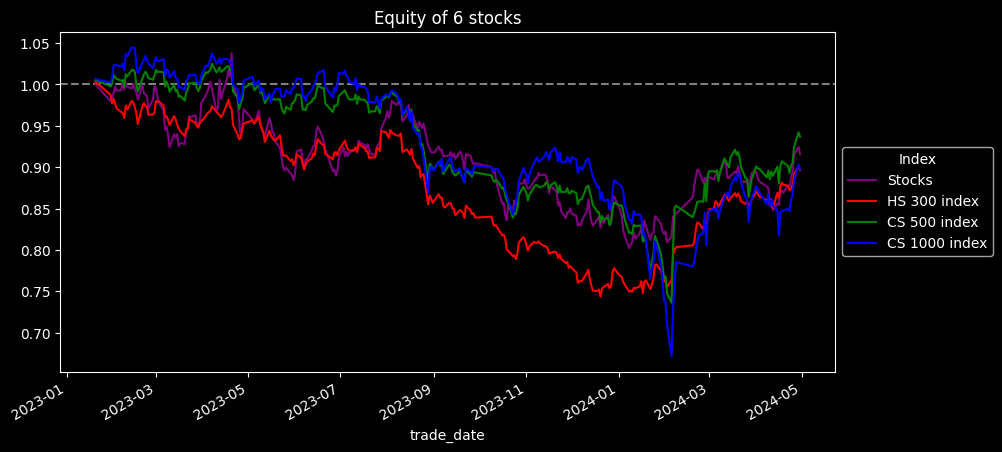

In [116]:
Simple_Backtest(Ensemble_weight_factor_df, 6, True)

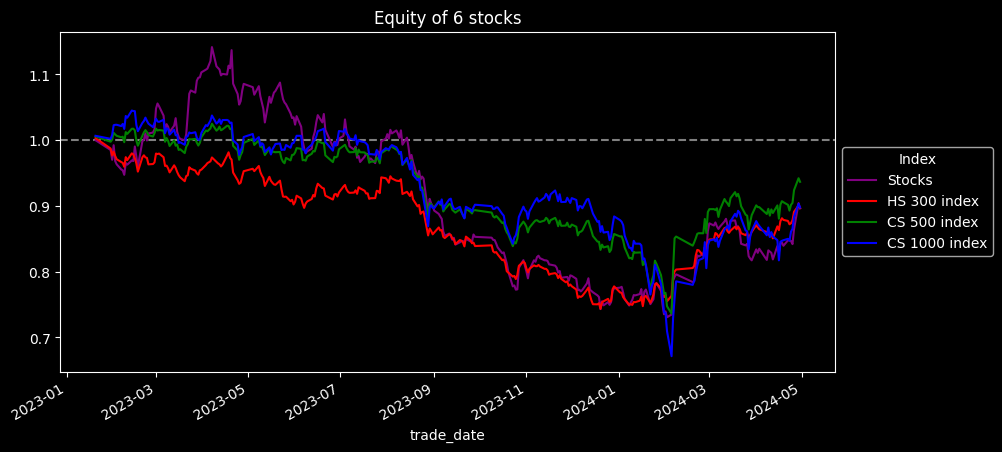

In [106]:
Simple_Backtest(Ensemble_weight_factor_df, 6, False)

In [ ]:
# Simple_Backtest(Ensemble_max_factor_df, 6, True)

### Indexes

1. RankIC mean(IC mean)
2. ICIR
3. IC winning rate
4. IC t-value
5. Long ROI
6. Long sharp
7. Long retracement
8. Long average weekly turnover rate

In [16]:
def Backtest_Indexes(factor_df, Profit_Long):
    # ICIR
    IC_series = factor_df.corrwith(price_return_backtest, axis=1, method="spearman")
    IC_mean = IC_series.mean()
    print(f"IC mean: {IC_mean}")
    ICIR = IC_series.mean() / IC_series.std()
    print(f"ICIR: {ICIR}")
    IC_series.hist(bins=30)

    # RankIC
    # Create a figure and axis
    _, ax = plt.subplots(figsize=(8, 4))
    # Plot histogram of values on the left side
    ax.bar(IC_series.index, IC_series.values)
    ax.set_title('Histogram of Series Values')
    ax.set_xlabel('Date')
    ax.set_ylabel('RankIC')
    # Create a twin Axes sharing the xaxis
    ax2 = ax.twinx()
    # Plot cumulative line on the right side
    ax2.plot(IC_series.index, IC_series.cumsum(), color='orange')
    ax2.set_ylabel('Cumulative Sum')
    
    # IC winning rate
    IC_winning_rate = sum(1 for ic in IC_series if ic > 0) / len(IC_series)
    print(f"IC winning rate: {IC_winning_rate}")

    t_value = ICIR / sqrt(len(IC_series))
    print(f"IC t-value: {t_value}")

    # Long (Except Short), so `profit_long * 2`
    # profit_long is long equity series.
    Long_equity = Profit_Long * 2
    Long_ROI = (Long_equity.iloc[-1]) - 1
    print(f"Long ROI: {Long_ROI}")

    # Max Drawdown
    # Calculate the previous peaks
    previous_peaks = Long_equity.cummax()
    # Calculate the drawdowns
    drawdowns = (Long_equity - previous_peaks) / previous_peaks

    # Find the maximum drawdown and the dates associated with it
    # Convert the index labels to a numeric format
    drawdowns.index = pd.to_numeric(drawdowns.index)
    max_drawdown = drawdowns.min()
    print(f"Max drawdown: {max_drawdown}")
    max_drawdown_start = drawdowns.idxmin()

    # Convert the start and end dates back to the original format if needed
    max_drawdown_start = pd.to_datetime(max_drawdown_start).date()
    print(f"Max drawdown begin date: {max_drawdown_start}")

    plt.show()

IC mean: -0.01234260654588443
ICIR: -0.10342358144270566
IC winning rate: 0.4592833876221498
IC t-value: -0.005902695568858248
Long ROI: -0.05146401366986164
Max drawdown: -0.23521813102142308
Max drawdown begin date: 2024-01-22


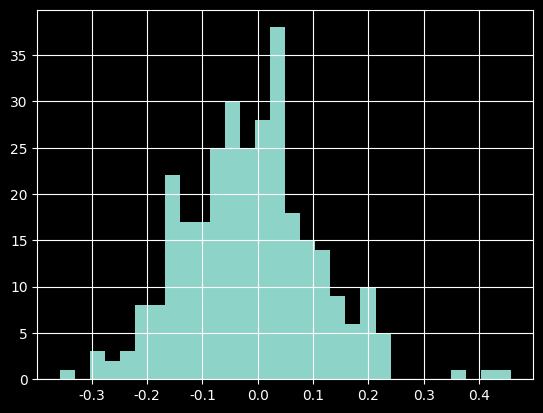

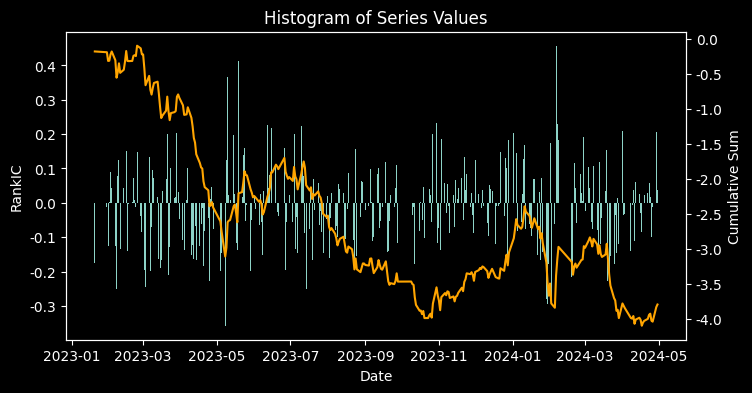

In [21]:
Backtest_Indexes(Ensemble_weight_factor_df, profit_long_Ensemble_weight)

IC mean: -0.009721636065541515
ICIR: -0.07188693263874028
IC winning rate: 0.4788273615635179
IC t-value: -0.004102803952699812
Long ROI: -0.04494175426905511
Max drawdown: -0.2222974605153109
Max drawdown begin date: 2024-02-05


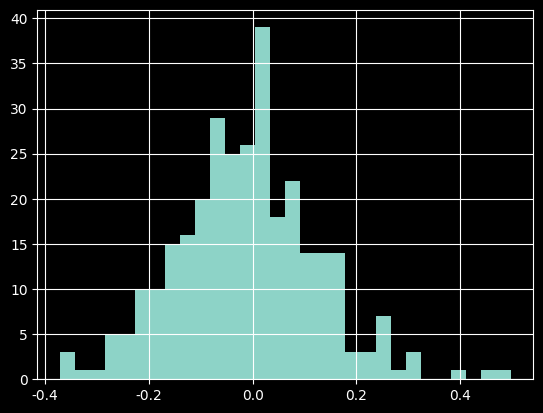

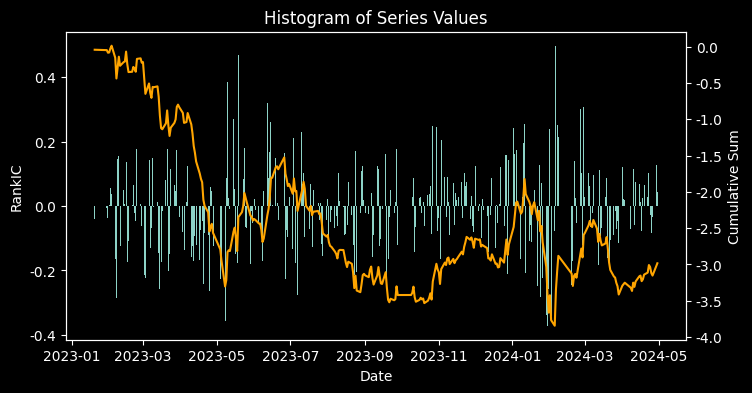

In [22]:
Backtest_Indexes(Ensemble_max_factor_df, profit_long_Ensemble_max)